# Bass Strait wave hindcast demo

This notebook shows examples on how to interact with the Oceanum Bass Strait wave hindcast data using the Datamesh [python client](https://oceanum-python.readthedocs.org/).

Please note that you will need access to the Bass Strait hindcast datasets to run this notebook yourself.

The Datamesh API documentation can be accessed from https://gateway.datamesh.oceanum.io/oceanql/docs#/.


## Required python libraries

- oceanum
- matplotlib
- cartopy
- xarray
- pandas
- geopandas
- wavespectra

In [1]:
import os
import geopandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import wavespectra

from oceanum.datamesh import Connector

import warnings
warnings.filterwarnings("ignore")

## 1. Datamesh connector

Put your datamesh token in the Jupyterlab settings, or as the `token` argument in the constructor below

In [2]:
datamesh = Connector(token=None)

## 2. Search for the datasources

Search for the Oceanum Bass Strait wave hindcast in Datamesh using the [get_catalog](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Connector.html#oceanum.datamesh.Connector.get_catalog) method which returns a catalog with all datasources matching the searching criteria

In [3]:
cat = datamesh.get_catalog("tags:bass")
list(cat)

[
         Oceanum Portland 1km wave hindcast spectra [oceanum_wave_ptlan_1km_era5_spec]
             Extent: (140.35000610351562, -39.099998474121094, 142.8000030517578, -37.900001525878906)
             Timerange: 1993-01-01 00:00:00+00:00 to 2024-01-01 00:00:00+00:00
         ,
 
         Oceanum Bass Strait 5km wave hindcast parameters [oceanum_wave_bass_5km_era5_grid]
             Extent: (140.0, -42.0, 151.0, -37.0)
             Timerange: 1993-01-01 00:00:00+00:00 to 2024-01-01 00:00:00+00:00
         ,
 
         Oceanum Bass Strait 5km wave hindcast spectra [oceanum_wave_bass_5km_era5_spec]
             Extent: (140.1999969482422, -41.79999923706055, 150.8000030517578, -37.20000076293945)
             Timerange: 1993-01-01 00:00:00+00:00 to 2024-01-01 00:00:00+00:00
         ,
 
         Oceanum Eastern Bass 1km wave hindcast parameters [oceanum_wave_ebass_1km_era5_grid]
             Extent: (145.64999389648438, -41.25, 148.64999389648438, -37.75)
             Timerange: 1993-

Each entry in the catalog is a Datamesh [Datasource](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Datasource.html#oceanum.datamesh.Datasource) object which holds a number of attributes defining the data such as `variables`, `coordinates`, `schema`, `tstart`, `tend` and others. Datasource instances can also be directly created from the datasource ID using the `get_datasource` method:

In [4]:
ds = datamesh.get_datasource("oceanum_wave_bass_5km_era5_grid")
ds


        Oceanum Bass Strait 5km wave hindcast parameters [oceanum_wave_bass_5km_era5_grid]
            Extent: (140.0, -42.0, 151.0, -37.0)
            Timerange: 1993-01-01 00:00:00+00:00 to 2024-01-01 00:00:00+00:00
            7 attributes
            38 variables
        

In [5]:
ds.description

'Oceanum SWAN Bass Strait 5km wave hindcast forced with ERA5, gridded parameters'

In [6]:
ds.tstart

datetime.datetime(1993, 1, 1, 0, 0, tzinfo=TzInfo(UTC))

In [7]:
ds.tend

datetime.datetime(2024, 1, 1, 0, 0, tzinfo=TzInfo(UTC))

In [8]:
ds.variables.keys()

dict_keys(['hs', 'dpm', 'tps', 'dspr', 'fspr', 'hsea', 'hswe', 'phs0', 'phs1', 'phs2', 'phs3', 'ptp0', 'ptp1', 'ptp2', 'ptp3', 'tm01', 'tm02', 'xcur', 'xwnd', 'ycur', 'ywnd', 'depth', 'pdir0', 'pdir1', 'pdir2', 'pdir3', 'dpmsea', 'dpmswe', 'pdspr0', 'pdspr1', 'pdspr2', 'pdspr3', 'pwlen0', 'pwlen1', 'pwlen2', 'pwlen3', 'tpssea', 'tpsswe'])

## 3. Working with the parameters data

### 3.1 Grid snapshot

#### Query a snapshot of gridded Hs to visualise spatial patterns

In [9]:
def query_snapshot(datasource: str, time: str):
    query = {
        "datasource": datasource,
        "variables": ["hs", "depth"],
        "timefilter": {
            "type": "range",
            "times": [time, time],
        },
    }
    return datamesh.query(query).squeeze()

In [10]:
time = "2020-01-01T00:00"
bass = query_snapshot("oceanum_wave_bass_5km_era5_grid", time=time)
ebass = query_snapshot("oceanum_wave_ebass_1km_era5_grid", time=time)
ptlan = query_snapshot("oceanum_wave_ptlan_1km_era5_grid", time=time)
bass

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 221)
Coordinates:
  * latitude   (latitude) float32 -42.0 -41.95 -41.9 ... -37.1 -37.05 -37.0
  * longitude  (longitude) float32 140.0 140.1 140.1 140.1 ... 150.9 150.9 151.0
    time       datetime64[ns] 2020-01-01
Data variables:
    hs         (latitude, longitude) float32 4.711 4.704 4.693 ... 1.85 1.869
    depth      (latitude, longitude) float32 4.795e+03 4.856e+03 ... 4.61e+03
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 Bass Strait
    run:                     bass
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           179864

#### Load a subset of the OSM land polygon for plotting

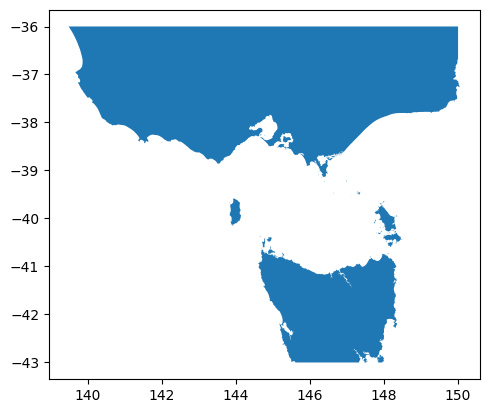

In [12]:
x0, x1 = bass.longitude.values[[0, -1]]
y0, y1 = bass.latitude.values[[0, -1]]
query = {
    "datasource": "osm-land-polygons",
    "geofilter": {
        "type": "bbox",
        "geom": [float(x0), float(y0), float(x1), float(y1)],
    }
}
land = datamesh.query(query).dissolve()
p = land.plot()

#### Map overlaying the different domains

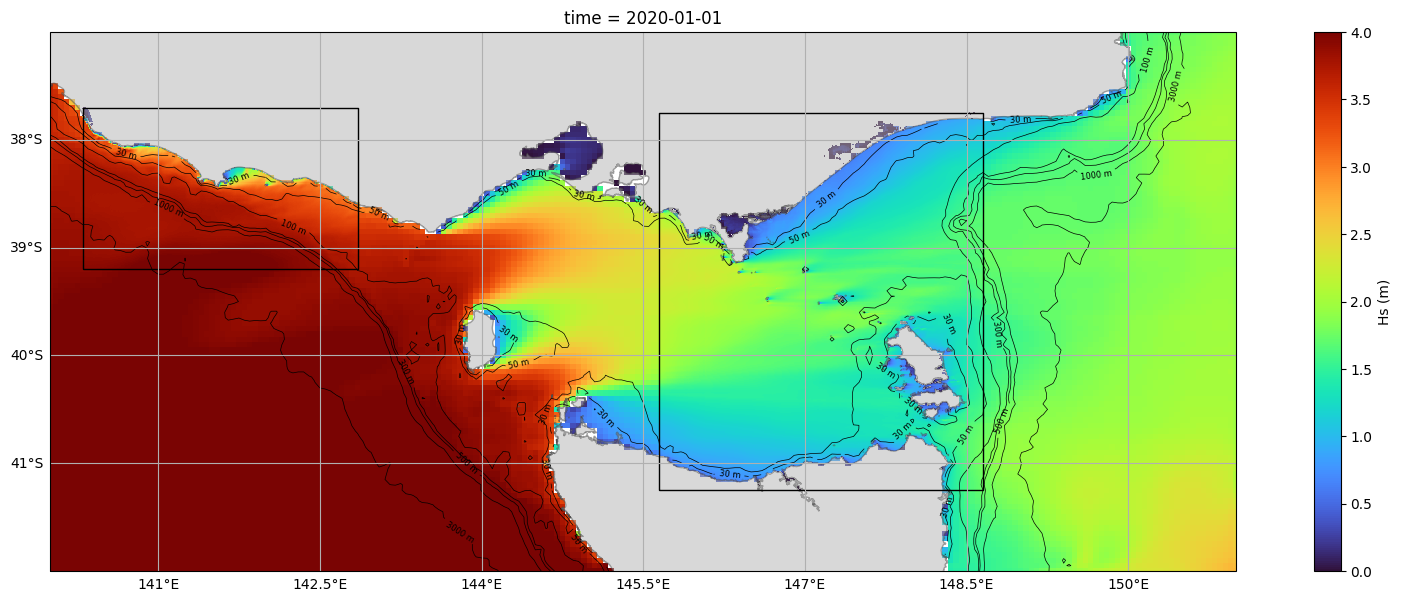

In [13]:
projection = transform = ccrs.PlateCarree()
vmin = 0
vmax = 4.0

fig, ax = plt.subplots(figsize=(20, 7), subplot_kw=dict(projection=projection))

# Plot Hs maps
for dset in [bass, ebass, ptlan]:
    p = dset.hs.plot(ax=ax, transform=transform, cmap="turbo", vmin=vmin, vmax=vmax, add_colorbar=False)
plt.colorbar(p, label="Hs (m)")

# Plot bathy contours
c = bass.depth.plot.contour(ax=ax, transform=transform, levels=[30, 50, 100, 300, 500, 1000, 3000], colors="k", linewidths=0.5)
c.clabel(fmt="%0.0f m", fontsize=6)

# Overlay the OSM land mask
land.plot(ax=ax, transform=transform, edgecolor="0.3", facecolor="0.7", alpha=0.5)

# Get and plot grid bounds from the 1km nests
for datasource in ["oceanum_wave_ebass_1km_era5_grid", "oceanum_wave_ptlan_1km_era5_grid"]:
    grid = geopandas.GeoSeries(datamesh.get_datasource(datasource).geom)
    grid.plot(ax=ax, transform=transform, edgecolor="k", facecolor="none")

ax.set_extent([x0, x1, y0, y1], crs=transform)
ax.gridlines(draw_labels=["left", "bottom"]);

### 3.2. Hindcast timeseries

#### Query timeseries at a single point

In [15]:
def query_timeseries(
    datasource: str,
    lon: float,
    lat: float,
    t0: str = None,
    t1: str = None,
    variables: list = ["hs", "tps", "dpm"],
):
    query = {
        "datasource": datasource,
        "variables": variables,
        "timefilter": {
            "type": "range",
            "times": [t0, t1],
        },
        "geofilter": {
            "type": "feature",
            "geom": {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": [[lon, lat]],
                },
            },
        },
    }
    return datamesh.query(query).squeeze()

#### 31 years of data from the 5 and 1 km domains

In [17]:
lon = 147
lat = -39.5

ts_bass = query_timeseries(datasource="oceanum_wave_bass_5km_era5_grid", lon=lon, lat=lat)
ts_ebass = query_timeseries(datasource="oceanum_wave_ebass_1km_era5_grid", lon=lon, lat=lat)
ts_ebass

<xarray.Dataset>
Dimensions:      (time: 271729)
Coordinates:
  * time         (time) datetime64[ns] 1993-01-01 ... 2024-01-01
    spatial_ref  int64 0
    longitude    float64 147.0
    latitude     float64 -39.5
Data variables:
    hs           (time) float64 0.01909 0.02368 0.03437 ... 0.7171 0.695 0.6797
    tps          (time) float64 nan nan nan nan 1.81 ... 13.33 13.36 13.34 13.27
    dpm          (time) float64 186.1 152.8 107.0 80.1 ... 246.6 246.5 246.4
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 Eastern Bass Str
    run:                     ebas
    xinterp_method:          linear
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           8695352

#### Plot the site location

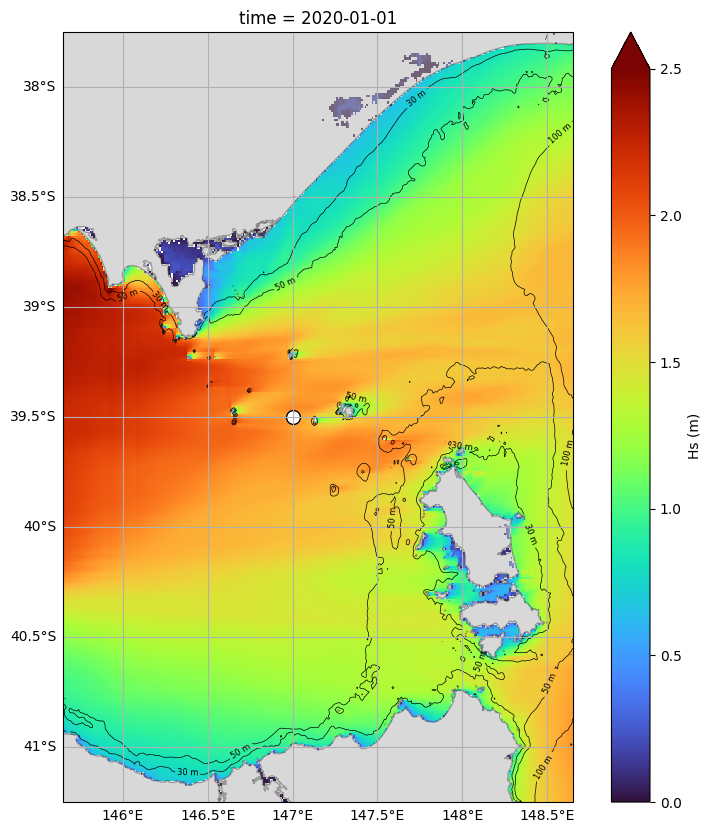

In [18]:
dset = ebass

x0, x1 = dset.longitude.values[[0, -1]]
y0, y1 = dset.latitude.values[[0, -1]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=projection))

# Plot Hs maps
dset.hs.plot(ax=ax, transform=transform, cmap="turbo", vmin=0, vmax=2.5, cbar_kwargs={"label": "Hs (m)"})

# Plot site location
ax.plot(lon, lat, "ow", markersize=10, markeredgecolor="k", transform=transform)

# Plot bathy contours
c = dset.depth.plot.contour(ax=ax, transform=transform, levels=[30, 50, 100], colors="k", linewidths=0.5)
c.clabel(fmt="%0.0f m", fontsize=6)

# Overlay the OSM land mask
land.plot(ax=ax, transform=transform, edgecolor="0.3", facecolor="0.7", alpha=0.5)

ax.set_extent([x0, x1, y0, y1], crs=transform)
ax.gridlines(draw_labels=["left", "bottom"]);

#### Plot timeseries from the 1km domain

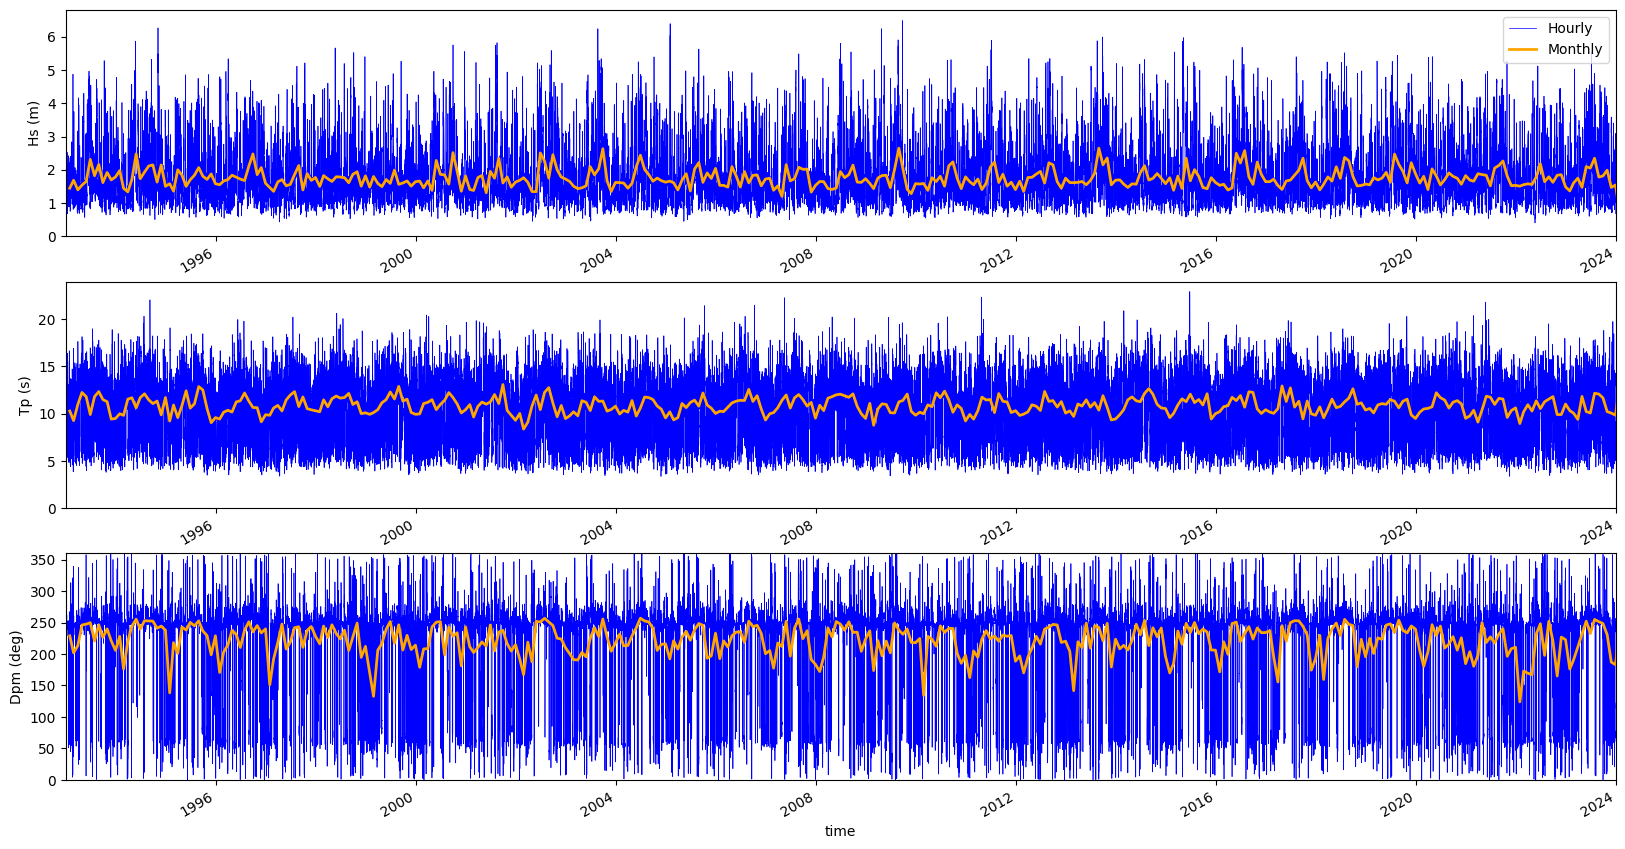

In [25]:
ts = ts_ebass
ts_monthly = ts.resample({"time": "1m"}).mean()

xlim = ts.time.to_index()[[0, -1]]

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

# Hs
ax = axs[0]
ts.hs.plot(ax=ax, color="b", linewidth=0.5, label="Hourly")
ts_monthly.hs.plot(ax=ax, color="orange", linewidth=2, label="Monthly")
ax.set_ylim([0, None])
ax.set_ylabel("Hs (m)")
ax.legend()

# Tp
ax = axs[1]
ts.tps.plot(ax=ax, color="b", linewidth=0.5)
ts_monthly.tps.plot(ax=ax, color="orange", linewidth=2)
ax.set_ylim([0, None])
ax.set_ylabel("Tp (s)")

# Dpm
ax = axs[2]
ts.dpm.plot(ax=ax, color="b", linewidth=0.5)
ts_monthly.dpm.plot(ax=ax, color="orange", linewidth=2)
ax.set_ylim([0, 360])
ax.set_ylabel("Dpm (deg)")

for ax in axs:
    ax.set_title("")
    ax.set_xlim(xlim)

#### Show some basic stats

In [26]:
ts.to_pandas()[["hs", "tps", "dpm"]].describe()

,hs,tps,dpm
count,271729.000000,271725.000000,271729.000000
mean,1.753490,10.851279,221.500830
std,0.836727,3.269478,69.159946
min,0.019093,1.810002,0.016496
25%,1.154736,7.779955,245.909195
50%,1.513681,11.619909,248.548599
75%,2.123889,13.452823,252.650665
max,6.487751,22.922113,359.964081


In [27]:
ts.groupby("time.season").mean().to_pandas()[["hs", "tps", "dpm"]]

,hs,tps,dpm
season,,,
DJF,1.612761,10.036839,199.991652
JJA,1.925236,11.470690,236.900721
MAM,1.683892,11.021870,224.069380
SON,1.789752,10.860071,224.661439


#### Compare the 5 and 1 km data

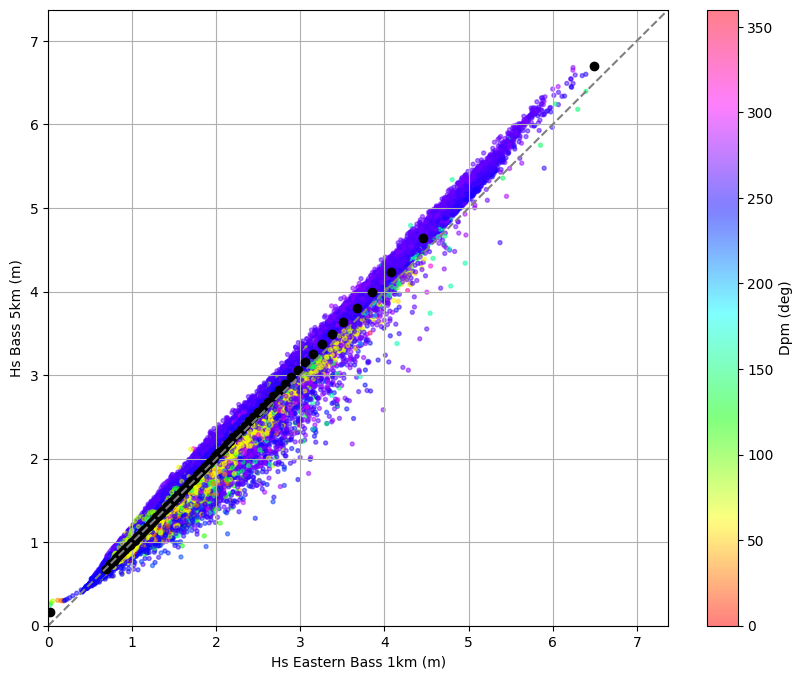

In [28]:
df = pd.concat([ts_bass.hs.to_pandas(), ts_ebass.hs.to_pandas(), ts_ebass.dpm.to_pandas()], axis=1)
df.columns = ["hs_5km", "hs_1km", "dpm_1km"]

xlim = ylim = [0, df[["hs_5km", "hs_1km"]].max().max() * 1.1]

fig, ax = plt.subplots(figsize=(10, 8))

# Plot points
p = ax.scatter(df.hs_1km, df.hs_5km, s=8, c=df.dpm_1km, cmap="hsv", vmin=0, vmax=360, alpha=0.5)
plt.colorbar(p, label="Dpm (deg)")

# Calculate and plot quantiles
dfq = df.quantile(q=np.arange(0, 1.01, 0.01))
ax.plot(dfq.hs_1km, dfq.hs_5km, "ok")

# Equality line
ax.plot(xlim, ylim, "--", color="0.5")

ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("Hs Eastern Bass 1km (m)")
ax.set_ylabel("Hs Bass 5km (m)");

### 3.3. Satellite altimeter verification

#### Load hindcast data away from the coast where satellite altimeter is more reliable

In [29]:
lon = 149.5
lat = -39.5

ts = query_timeseries(datasource="oceanum_wave_bass_5km_era5_grid", lon=lon, lat=lat)

# Remove the first days to avoid model spinup
ts = ts.sel(time=slice("19930103", None))
ts

<xarray.Dataset>
Dimensions:      (time: 271681)
Coordinates:
  * time         (time) datetime64[ns] 1993-01-03 ... 2024-01-01
    spatial_ref  int64 0
    longitude    float64 149.5
    latitude     float64 -39.5
Data variables:
    hs           (time) float64 1.968 1.985 1.987 1.975 ... 1.115 1.133 1.155
    tps          (time) float64 6.976 7.176 7.302 7.417 ... 9.459 9.387 9.339
    dpm          (time) float64 43.74 43.9 44.06 44.2 ... 183.8 185.7 187.5
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 Bass Strait
    run:                     bass
    xinterp_method:          linear
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           8695352

#### Load satellite altimeter data within a 1-degree square centered at the site location

In [30]:
win = 0.5
query = dict(
    datasource="imos_wave_wind",
    variables=["swh_ku_cal", "swh_ku_quality_control", "platform"],
    geofilter={"type": "bbox", "geom":[lon-win, lat-win, lon+win, lat+win]}
)
dfsat = datamesh.query(query)
dfsat

,time,longitude,latitude,swh_ku_cal,swh_ku_quality_control,platform,geometry
0,1991-12-18 12:58:09.124999,149.95004,-39.501663,1.693,1.0,ERS-1,POINT (149.95004 -39.50166)
1,1991-12-18 12:58:10.109373,149.93147,-39.444283,1.903,1.0,ERS-1,POINT (149.93147 -39.44428)
2,1991-12-18 12:58:11.085942,149.91293,-39.386887,1.938,1.0,ERS-1,POINT (149.91293 -39.38689)
3,1991-12-18 12:58:12.070316,149.89441,-39.329487,1.845,1.0,ERS-1,POINT (149.89441 -39.32949)
4,1991-12-18 12:58:13.046875,149.87592,-39.272083,1.705,1.0,ERS-1,POINT (149.87592 -39.27208)
...,...,...,...,...,...,...,...
62556,2023-06-13 20:24:49.578123,150.00000,-39.034000,2.450,1.0,CFOSAT,POINT (150.00000 -39.03400)
62557,2023-08-30 20:21:29.499999,150.00000,-39.048000,2.142,1.0,CFOSAT,POINT (150.00000 -39.04800)
62558,2023-09-25 20:20:03.656248,150.00000,-39.404000,2.234,1.0,CFOSAT,POINT (150.00000 -39.40400)
62559,2023-10-21 20:19:03.734374,150.00000,-39.223000,2.402,1.0,CFOSAT,POINT (150.00000 -39.22300)


#### Keep only the "good" and "probably_good" data (see https://www.nature.com/articles/s41597-019-0083-9)

In [31]:
dfsat = dfsat.loc[dfsat.swh_ku_quality_control <= 2]
dfsat.shape

(59888, 7)

#### Map to show site and satellite passes

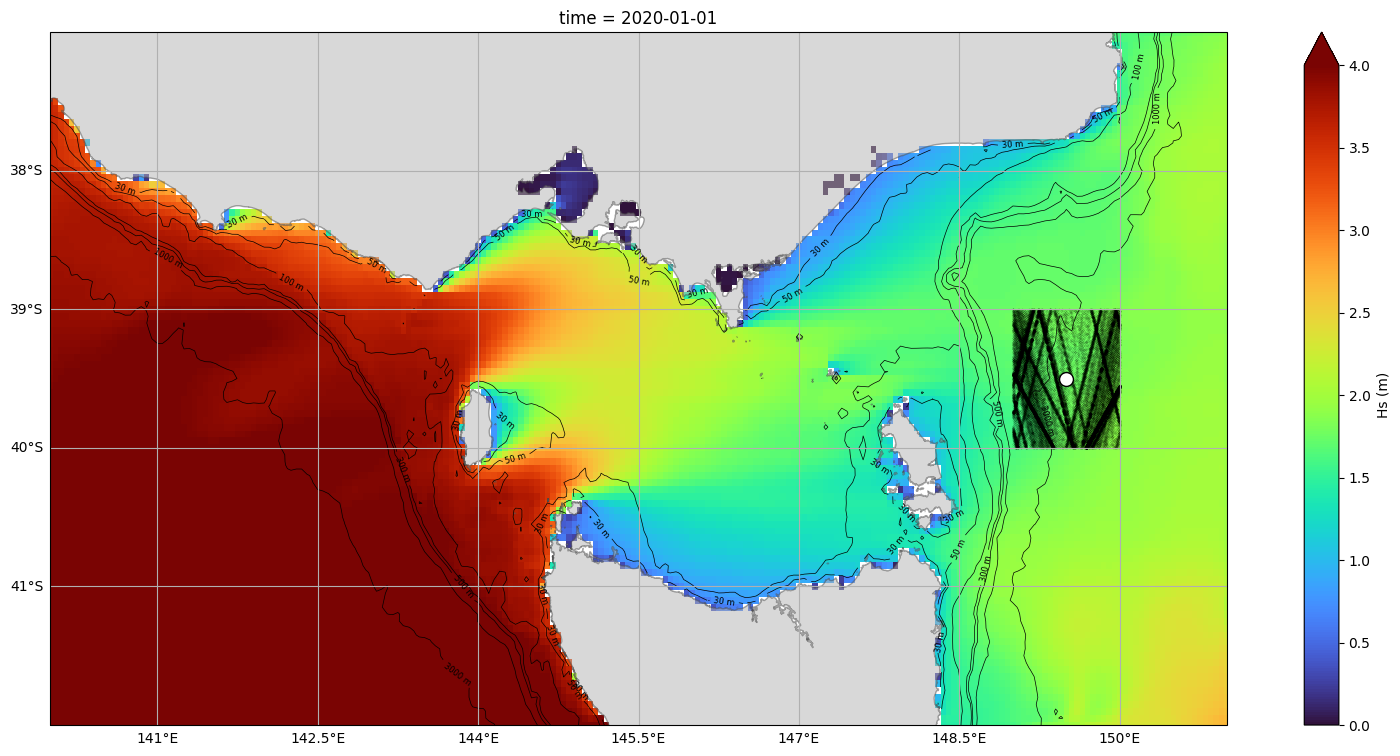

In [33]:
dset = bass

x0, x1 = dset.longitude.values[[0, -1]]
y0, y1 = dset.latitude.values[[0, -1]]

fig, ax = plt.subplots(figsize=(20, 9), subplot_kw=dict(projection=projection))

# Plot Hs maps
dset.hs.plot(ax=ax, transform=transform, cmap="turbo", vmin=0, vmax=4.0, cbar_kwargs={"label": "Hs (m)"})

# Plot satellite passes
ax.plot(dfsat.longitude, dfsat.latitude, ".k", markersize=0.2, alpha=0.5)

# Plot site location
ax.plot(lon, lat, "ow", markersize=10, markeredgecolor="k", transform=transform)

# Plot bathy contours
c = dset.depth.plot.contour(ax=ax, transform=transform, levels=[30, 50, 100, 300, 500, 1000, 3000], colors="k", linewidths=0.5)
c.clabel(fmt="%0.0f m", fontsize=6)

# Overlay the OSM land mask
land.plot(ax=ax, transform=transform, edgecolor="0.3", facecolor="0.7", alpha=0.5)

ax.set_extent([x0, x1, y0, y1], crs=transform)
ax.gridlines(draw_labels=["left", "bottom"]);

#### Colocate data

Interpolate hindcast at the satellite times

In [34]:
df = dfsat[["time", "swh_ku_cal", "longitude", "latitude", "platform"]].set_index("time")
df["swh_hindcast"] = ts.hs.interp(time=df.index).to_pandas()
df["tp_hindcast"] = ts.tps.interp(time=df.index).to_pandas()
df = df.rename(columns={"swh_ku_cal": "x", "swh_hindcast": "y"}).dropna()
df.head()

,x,longitude,latitude,platform,y,tp_hindcast
time,,,,,,
1993-01-06 12:57:58.132814,1.752,149.99583,-39.090270,ERS-1,1.345420,8.151445
1993-01-06 12:57:59.109372,2.032,149.97740,-39.032883,ERS-1,1.345428,8.151448
1993-01-20 00:05:17.350582,0.305,149.20183,-39.117430,ERS-1,1.036049,6.287412
1993-01-20 00:05:18.330812,1.262,149.18336,-39.174805,ERS-1,1.036038,6.287409
1993-01-20 00:05:19.311283,2.347,149.16487,-39.232190,ERS-1,1.036028,6.287406


#### Functions to compute error statistics

In [37]:
def n(df: pd.DataFrame):
    """Number of colocations."""
    return df.dropna().shape[0]


def mad(df: pd.DataFrame):
    """Mean absolute difference MAD."""
    return (df.y - df.x).abs().mean()


def rmsd(df: pd.DataFrame):
    """Root-mean-square difference RMSD."""
    return np.sqrt(((df.y - df.x)**2).mean())


def bias(df: pd.DataFrame):
    """Bias."""
    return (df.y - df.x).mean()

def si(df: pd.DataFrame):
    """Scatter Index."""
    return np.sqrt((((df.y - df.x) - bias(df))**2).mean() ) / df.x.mean()

#### Plot data

In [40]:
def get_color_mapping(df, cmap="tab20"):
    """Get the colors and legend handles to make a scatter with satellite labels."""
    df["label"] = df.platform.str.strip()
    cm = plt.cm.get_cmap(cmap, df.label.unique().size)
    platform_to_color = {label: cm(i) for i, label in enumerate(df.label.unique())}
    colors = df["label"].map(platform_to_color)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=l) for l, c in platform_to_color.items()]
    return colors, legend_handles

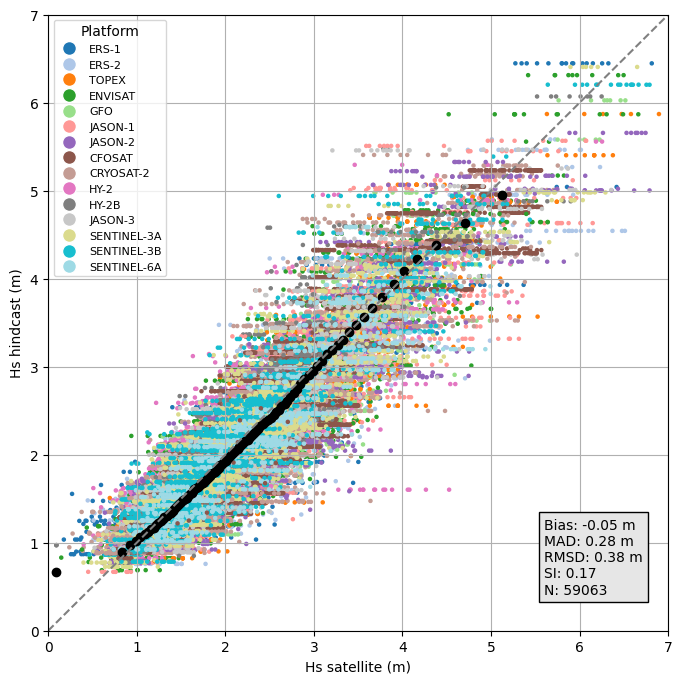

In [42]:
cmap = "tab20"
xlim = ylim = [0, 7]

fig, ax = plt.subplots(figsize=(8, 8))

# Plot points
colors, legend_handles = get_color_mapping(df, cmap)
p = ax.scatter(df["x"], df["y"], s=5, c=colors, vmin=None, vmax=None, alpha=1.0)
ax.legend(handles=legend_handles, title="Platform", fontsize=8)

# Calculate and plot quantiles
dfq = df[["x", "y"]].quantile(q=np.arange(0, 1.01, 0.01))
ax.plot(dfq["x"], dfq["y"], "ok")

# Equality line
ax.plot(xlim, ylim, "--", color="0.5")

# Show error statistics
text = f"Bias: {bias(df):0.2f} m\nMAD: {mad(df):0.2f} m\nRMSD: {rmsd(df):0.2f} m\nSI: {si(df):0.2f}\nN: {n(df):0.0f}"
ax.annotate(text, xy=(0.80, 0.06), xycoords="axes fraction", fontsize=10, fontweight="normal", color="0.0", bbox=dict(facecolor="0.9"))

ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("Hs satellite (m)")
ax.set_ylabel("Hs hindcast (m)");

## 4. Working with the spectra data

### 4.1. Check spectra output locations

Get spectra coords from lazy representations of the datasources

In [43]:
bass_lazy = datamesh.load_datasource("oceanum_wave_bass_5km_era5_spec")
ebass_lazy = datamesh.load_datasource("oceanum_wave_ebass_1km_era5_spec")
ptlan_lazy = datamesh.load_datasource("oceanum_wave_ptlan_1km_era5_spec")
bass_lazy

<xarray.Dataset>
Dimensions:  (dir: 36, time: 271729, site: 276, freq: 32)
Coordinates:
  * dir      (dir) float32 265.0 255.0 245.0 235.0 ... 305.0 295.0 285.0 275.0
  * freq     (freq) float32 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * site     (site) int64 1 2 3 4 5 6 7 8 9 ... 269 270 271 272 273 274 275 276
  * time     (time) datetime64[ns] 1993-01-01 1993-01-01T01:00:00 ... 2024-01-01
Data variables:
    dpt      (time, site) float32 dask.array<chunksize=(8192, 4), meta=np.ndarray>
    efth     (time, site, freq, dir) float64 dask.array<chunksize=(8192, 4, 32, 36), meta=np.ndarray>
    lat      (site) float32 dask.array<chunksize=(276,), meta=np.ndarray>
    lon      (site) float32 dask.array<chunksize=(276,), meta=np.ndarray>
    wdir     (time, site) float32 dask.array<chunksize=(8192, 4), meta=np.ndarray>
    wspd     (time, site) float32 dask.array<chunksize=(8192, 4), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 Bass Strait
    run:                     bass

#### Show locations on a map

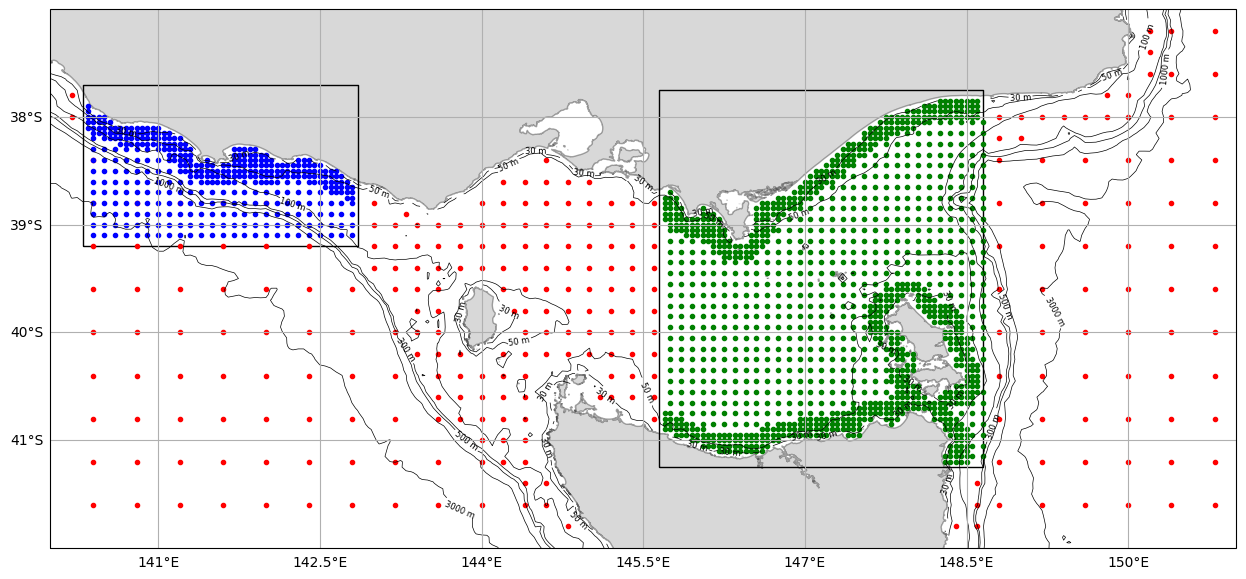

In [44]:
fig, ax = plt.subplots(figsize=(20, 7), subplot_kw=dict(projection=projection))

ax.plot(bass_lazy.lon.values, bass_lazy.lat.values, ".r")
ax.plot(ebass_lazy.lon.values, ebass_lazy.lat.values, ".g")
ax.plot(ptlan_lazy.lon.values, ptlan_lazy.lat.values, ".b")

# Plot bathy contours
c = bass.depth.plot.contour(ax=ax, transform=transform, levels=[30, 50, 100, 300, 500, 1000, 3000], colors="k", linewidths=0.5)
c.clabel(fmt="%0.0f m", fontsize=6)

# Overlay the OSM land mask
land.plot(ax=ax, transform=transform, edgecolor="0.3", facecolor="0.7", alpha=0.5)

# Get and plot grid bounds from the 1km nests
for datasource in ["oceanum_wave_ebass_1km_era5_grid", "oceanum_wave_ptlan_1km_era5_grid"]:
    grid = geopandas.GeoSeries(datamesh.get_datasource(datasource).geom)
    grid.plot(ax=ax, transform=transform, edgecolor="k", facecolor="none")

ax.set_title("")
ax.set_extent([x0, x1, y0, y1], crs=transform)
ax.gridlines(draw_labels=["left", "bottom"]);

### 4.2. Load timeseries

Query timeseries from spectra and parameters datasets over 1 year to compare

In [48]:
lon = 147.45
lat = -38.85
t0 = "20230101T00"
t1 = "20240101T00"

ts_param = query_timeseries(
    datasource="oceanum_wave_ebass_1km_era5_grid",
    lon=lon,
    lat=lat,
    t0=t0,
    t1=t1,
    variables=["hs", "tps", "dpm"],
)
ts_spec = query_timeseries(
    datasource="oceanum_wave_ebass_1km_era5_spec",
    lon=lon,
    lat=lat,
    t0=t0,
    t1=t1,
    variables=None, # Get all variables
)

ts_spec

<xarray.Dataset>
Dimensions:      (dir: 36, time: 8761, freq: 32)
Coordinates:
  * dir          (dir) float32 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq         (freq) float32 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
    lat          float32 -38.85
    lon          float32 147.4
    site         int64 325
  * time         (time) datetime64[ns] 2023-01-01 ... 2024-01-01
    spatial_ref  int64 0
Data variables:
    dpt          (time) float32 63.97 63.97 63.97 63.97 ... 63.97 63.97 63.97
    efth         (time, freq, dir) float64 0.0 0.0 0.0 1e-05 ... 0.0 0.0 0.0 0.0
    wdir         (time) float32 54.16 54.76 58.73 63.37 ... 75.9 77.95 89.59
    wspd         (time) float32 7.025 6.875 6.308 5.943 ... 3.008 2.456 1.703
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 Eastern Bass Str
    run:                     ebas
    xinterp_method:          nearest
    _coordinates:            {"d":"dir","f":"freq","t":"time","x":"lon","y":"...
    _request_size:           80916892

### 4.3. Integrate spectra and compare against parameters

Use the [wavespectra](https://github.com/wavespectra/wavespectra) library to calculated spectral parameters

In [51]:
ts_param_from_spec = ts_spec.spec.stats(["hs", "tp", "dpm"]).load()

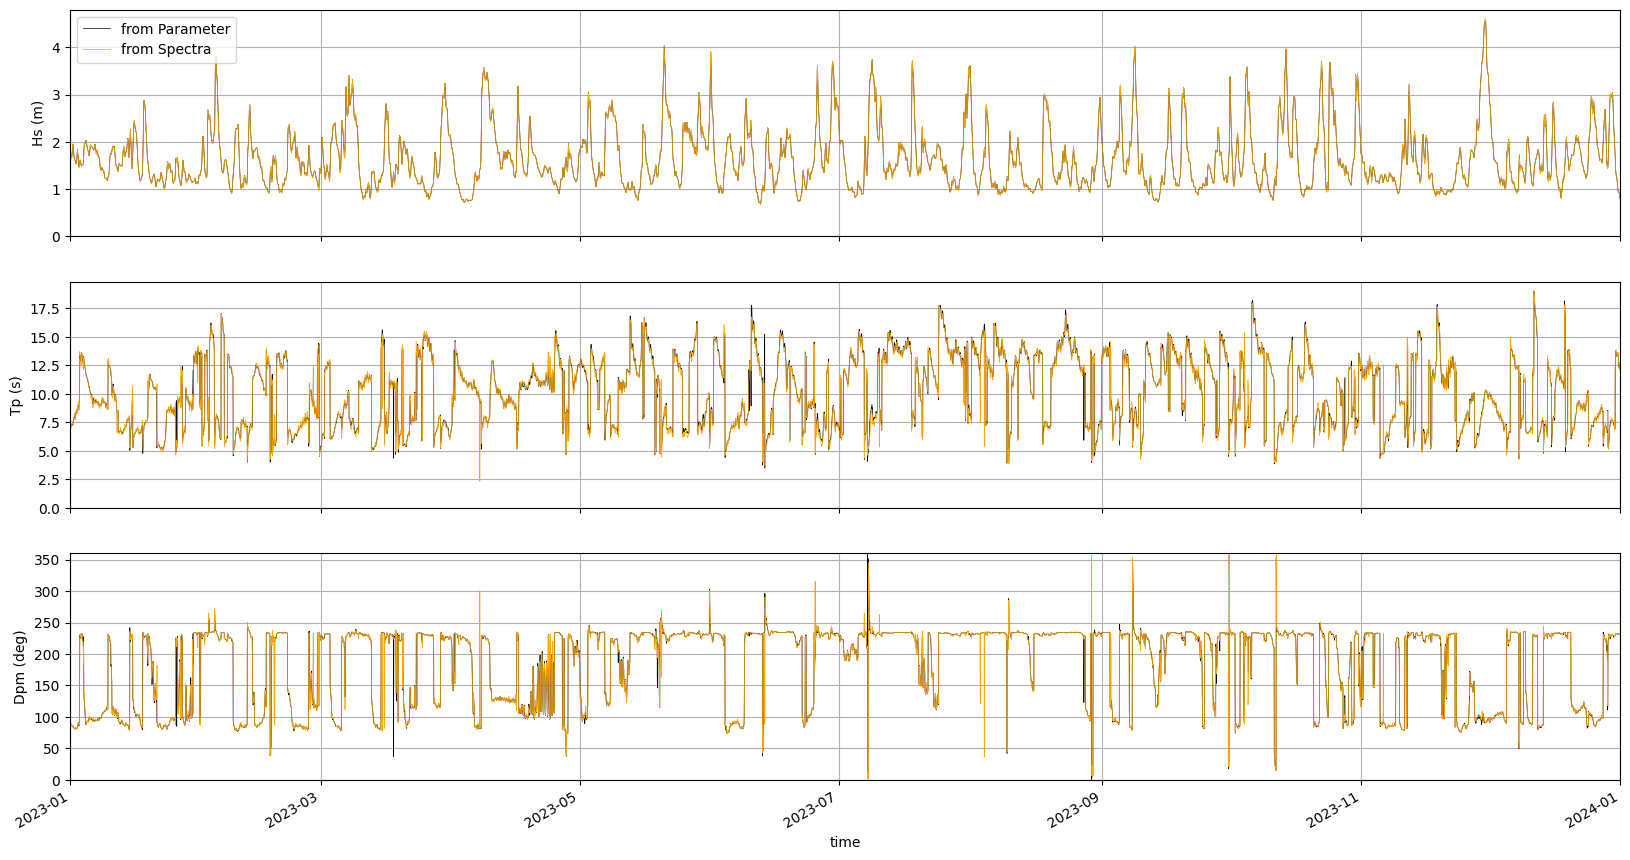

In [52]:
xlim = ts_param.time.to_index()[[0, -1]]

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

# Hs
ax = axs[0]
ts_param.hs.plot(ax=ax, color="k", linewidth=0.5, label="from Parameter")
ts_param_from_spec.hs.plot(ax=ax, color="orange", linewidth=0.5, label="from Spectra")
ax.set_ylim([0, None])
ax.set_ylabel("Hs (m)")
ax.legend()

# Tp
ax = axs[1]
ts_param.tps.plot(ax=ax, color="k", linewidth=0.5, label="from Parameter")
ts_param_from_spec.tp.plot(ax=ax, color="orange", linewidth=0.5, label="from Spectra")
ax.set_ylim([0, None])
ax.set_ylabel("Tp (s)")

# Dpm
ax = axs[2]
ts_param.dpm.plot(ax=ax, color="k", linewidth=0.5, label="from Parameter")
ts_param_from_spec.dpm.plot(ax=ax, color="orange", linewidth=0.5, label="from Spectra")
ax.set_ylim([0, 360])
ax.set_ylabel("Dpm (deg)")

for ind, ax in enumerate(axs):
    ax.set_title("")
    ax.set_xlim(xlim)
    ax.grid()
    if ind < 2:
        ax.set_xlabel("")
        ax.set_xticklabels([])

### 4.4 Analyse spectra

Calculate and plot seasonal mean using xarray and wavespectra

In [53]:
ds = ts_spec.groupby("time.season").mean()
ds

<xarray.Dataset>
Dimensions:      (season: 4, freq: 32, dir: 36)
Coordinates:
  * dir          (dir) float32 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
    lat          float32 -38.85
    lon          float32 147.4
    site         int64 325
    spatial_ref  int64 0
  * freq         (freq) float32 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    dpt          (season) float32 63.97 63.97 63.97 63.97
    efth         (season, freq, dir) float64 1.388e-08 1.254e-06 ... 2.278e-05
    wdir         (season) float32 153.3 235.4 209.9 187.8
    wspd         (season) float32 7.094 7.728 7.639 7.514
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 Eastern Bass Str
    run:                     ebas
    xinterp_method:          nearest
    _coordinates:            {"d":"dir","f":"freq","t":"time","x":"lon","y":"...
    _request_size:           80916892

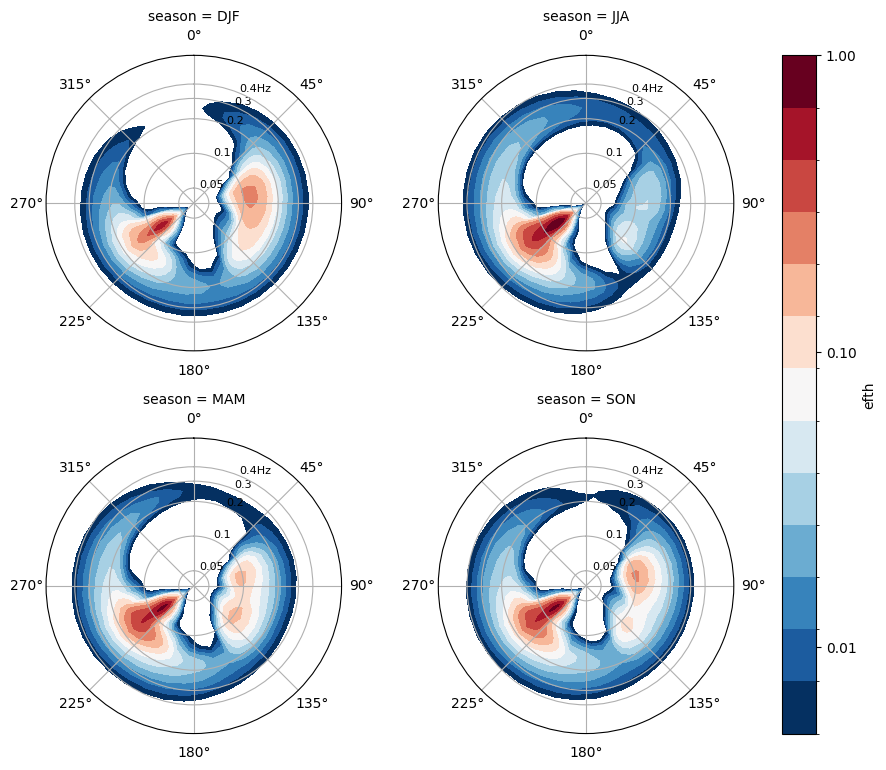

In [55]:
p = ds.spec.plot(col="season", col_wrap=2, figsize=(10, 8))

Plot timeseries of 1D spectra over one month

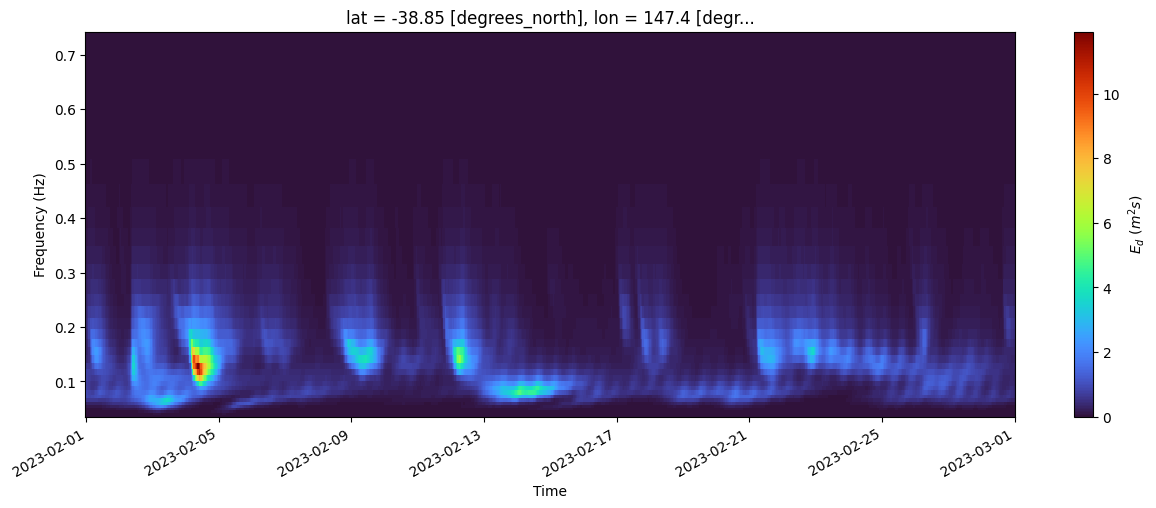

In [56]:
fig, ax = plt.subplots(figsize=(15, 5))

ds1d = ts_spec.sel(time=slice("20230201T00", "20230301T00")).spec.oned()
ds1d.plot(x="time", y="freq", vmax=None, cmap="turbo", cbar_kwargs={"label": "$E_d$ $(m^2s)$"})
ax.set_xlabel("Time")
ax.set_ylabel("Frequency (Hz)");